# TensorFlow 使用皮尔逊相关系数找出和标签相关性最大的特征值
我使用加利福尼亚州房价数据来作例子。训练集和验证集用到的CSV文件在这里：https://download.csdn.net/download/zhangchao19890805/10584496

测试集用到的CSV文件在这里：
https://download.csdn.net/download/zhangchao19890805/10631336

在实际应用的时候，我们往往会收集多个维度的特征值。然而这些特征值未必都能派上用场。有些特征值可能和标签没有什么太大关系，而另外一些特征值可能和标签有很大的相关性。相关性不大的特征值对于训练模型没有太大用处，还会影响性能。因此，最佳方式是找到相关性最大的几个特征值来训练模型。

那么，如何才能找到相关性最大的几个特征值呢？

为了解决这个问题，我们引入了皮尔逊相关系数（Pearson correlation coefficient）这一个数学工具。这里是皮尔逊相关系数的维基百科。 简单的解释，皮尔逊相关系数是衡量两个变量X和Y 线性相关性的工具。设 p 代表皮尔逊相关系数，p 是实数， p 大于等于 -1 并且 p 小于等于 1。其中0代表没有线性相关，-1 代表负线性相关，1代表正线性相关。具体看下面的图就会一目了然：



Python 的 pandas.DataFrame.corr 函数默认使用皮尔逊系数计算各个特征值的相关性，在本文的Demo中有演示。本文仍然使用加利福尼亚房价的那套数据进行演示。

我先写了个 ZcSummary 类来展示一下数据集的概要情况。这种做法在实际应用中可以及时发现数据集的异常情况。

ZcSummary :



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics
from IPython import display

class ZcSummary:
    # 从CSV文件中读取数据，返回DataFrame类型的数据集合。
    def read_csv(self):
        v_dataframe = pd.read_csv("california_housing_train.csv", sep=",")
        # 打乱数据集合的顺序。有时候数据文件有可能是根据某种顺序排列的，会影响到我们对数据的处理。
        v_dataframe = v_dataframe.reindex(np.random.permutation(v_dataframe.index))
        return v_dataframe
    
    # 预处理特征值
    def preprocess_features(self, california_housing_dataframe):
        selected_features = california_housing_dataframe[
            ["latitude",
             "longitude",
             "housing_median_age",
             "total_rooms",
             "total_bedrooms",
             "population",
             "households",
             "median_income"]
        ]
        processed_features = selected_features.copy()
        # 增加一个新属性：人均房屋数量。
        processed_features["rooms_per_person"] = (
            california_housing_dataframe["total_rooms"] /
            california_housing_dataframe["population"])
        return processed_features


    # 预处理标签
    def preprocess_targets(self, california_housing_dataframe):
        output_targets = pd.DataFrame()
        # 数值过大可能引起训练过程中的错误。因此要把房价数值先缩小成原来的
        # 千分之一，然后作为标签值返回。
        output_targets["median_house_value"] = (
            california_housing_dataframe["median_house_value"] / 1000.0)
        return output_targets
    
     # 主函数
    def main(self):
        tf.logging.set_verbosity(tf.logging.ERROR)
        pd.options.display.max_rows = 10
        pd.options.display.float_format = '{:.1f}'.format
        
        california_housing_dataframe = self.read_csv()
        # 对于训练集，我们从共 17000 个样本中选择前 12000 个样本。
        training_examples = self.preprocess_features(california_housing_dataframe.head(12000))
        training_targets = self.preprocess_targets(california_housing_dataframe.head(12000))
        # 对于验证集，我们从共 17000 个样本中选择后 5000 个样本。
        validation_examples = self.preprocess_features(california_housing_dataframe.tail(5000))
        validation_targets = self.preprocess_targets(california_housing_dataframe.tail(5000))
        
        # 展示数据集的概要情况。
        print("Training examples summary:")
        display.display(training_examples.describe())
        print("Validation examples summary:")
        display.display(validation_examples.describe())

        print("Training targets summary:")
        display.display(training_targets.describe())
        print("Validation targets summary:")
        display.display(validation_targets.describe())

t = ZcSummary()
t.main()



程序运行结果：

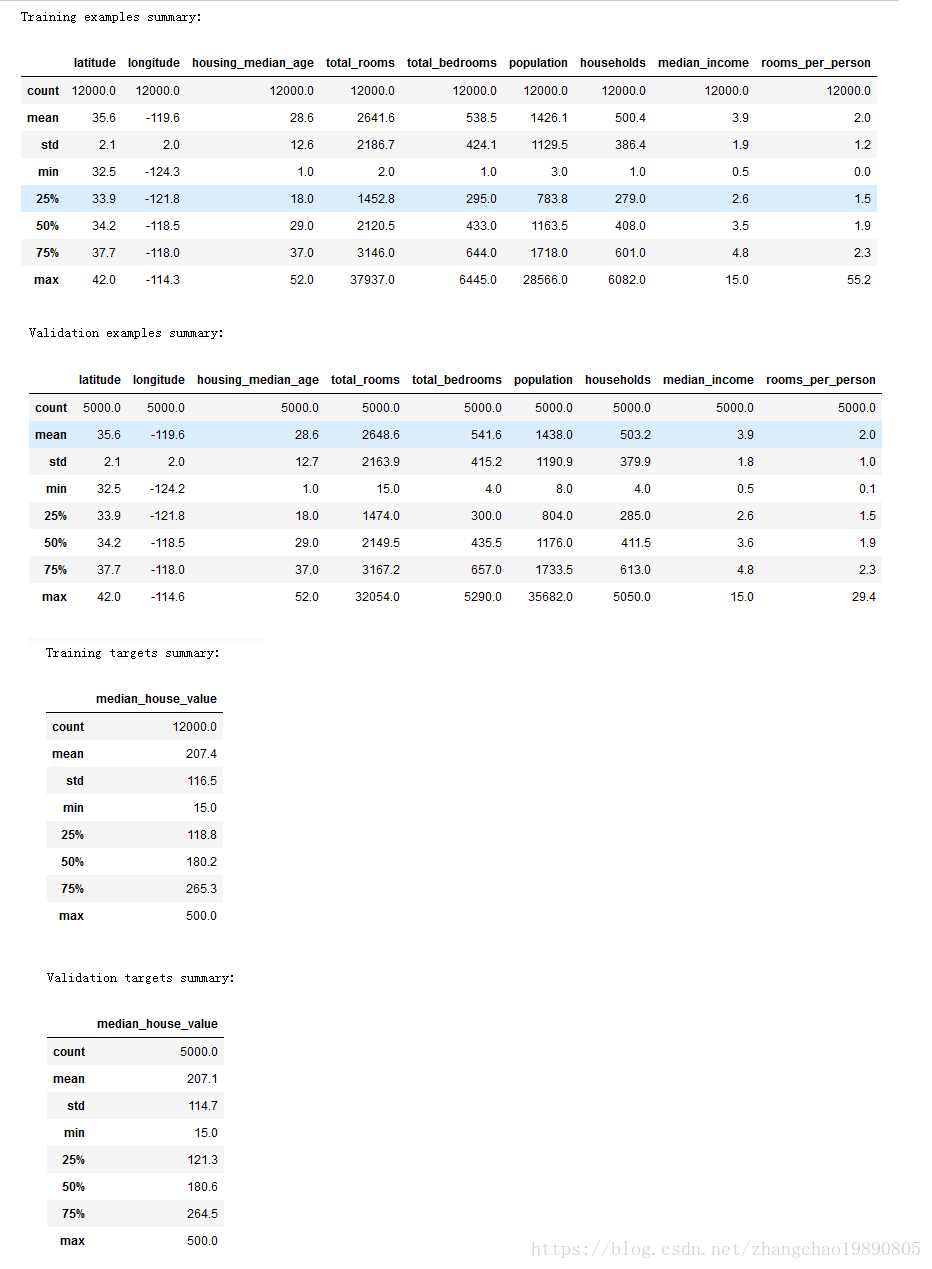

现在，我们要计算一下皮尔逊系数。ZcPearson类为我计算出了所有的皮尔逊相关系数，并展示了出来，下面是代码：

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics
from IPython import display

class ZcPearson:
    # 从CSV文件中读取数据，返回DataFrame类型的数据集合。
    def read_csv(self):
        v_dataframe = pd.read_csv("http://114.116.18.230/california_housing_train.csv", sep=",")
        # 打乱数据集合的顺序。有时候数据文件有可能是根据某种顺序排列的，会影响到我们对数据的处理。
        v_dataframe = v_dataframe.reindex(np.random.permutation(v_dataframe.index))
        return v_dataframe
    
    # 预处理特征值
    def preprocess_features(self, california_housing_dataframe):
        selected_features = california_housing_dataframe[
            ["latitude",
             "longitude",
             "housing_median_age",
             "total_rooms",
             "total_bedrooms",
             "population",
             "households",
             "median_income"]
        ]
        processed_features = selected_features.copy()
        # 增加一个新属性：人均房屋数量。
        processed_features["rooms_per_person"] = (
            california_housing_dataframe["total_rooms"] /
            california_housing_dataframe["population"])
        return processed_features


    # 预处理标签
    def preprocess_targets(self, california_housing_dataframe):
        output_targets = pd.DataFrame()
        # 数值过大可能引起训练过程中的错误。因此要把房价数值先缩小成原来的
        # 千分之一，然后作为标签值返回。
        output_targets["median_house_value"] = (
            california_housing_dataframe["median_house_value"] / 1000.0)
        return output_targets
    
     # 主函数
    def main(self):
        tf.logging.set_verbosity(tf.logging.ERROR)
        pd.options.display.max_rows = 10
        pd.options.display.float_format = '{:.1f}'.format
        
        california_housing_dataframe = self.read_csv()
        # 对于训练集，我们从共 17000 个样本中选择前 12000 个样本。
        training_examples = self.preprocess_features(california_housing_dataframe.head(12000))
        training_targets = self.preprocess_targets(california_housing_dataframe.head(12000))
        # 对于验证集，我们从共 17000 个样本中选择后 5000 个样本。
        validation_examples = self.preprocess_features(california_housing_dataframe.tail(5000))
        validation_targets = self.preprocess_targets(california_housing_dataframe.tail(5000))
        
        # 计算出各个特征值和标签值之间的皮尔逊相关系数，并打印出来
        correlation_dataframe = training_examples.copy()
        correlation_dataframe["target"] = training_targets["median_house_value"]
        corr_result = correlation_dataframe.corr()
        print(corr_result)

        
        
t = ZcPearson()
t.main()


运行结果：



查看结果，皮尔逊相关系数最大的特征值是median_income。除此之外，我们还希望有一些相互之间的相关性不太密切的特征，以便它们添加独立信息。从结果中看，可以认为纬度 latitude 比较符合要求。这样，我们确定了要训练的特征值是 median_income 和 latitude。现在我们开始训练模型，使用 ZcTrain 类：


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics
from IPython import display
  

class ZcTrain:
    # 从CSV文件中读取数据，返回DataFrame类型的数据集合。
    def read_csv(self):
        v_dataframe = pd.read_csv("http://114.116.18.230/california_housing_train.csv", sep=",")
        # 打乱数据集合的顺序。有时候数据文件有可能是根据某种顺序排列的，会影响到我们对数据的处理。
        v_dataframe = v_dataframe.reindex(np.random.permutation(v_dataframe.index))
        return v_dataframe
    
    
    
    # 预处理特征值
    def preprocess_features(self, california_housing_dataframe):
        selected_features = california_housing_dataframe[
            ["latitude",
             "longitude",
             "housing_median_age",
             "total_rooms",
             "total_bedrooms",
             "population",
             "households",
             "median_income"]
        ]
        processed_features = selected_features.copy()
        # 增加一个新属性：人均房屋数量。
        processed_features["rooms_per_person"] = (
            california_housing_dataframe["total_rooms"] /
            california_housing_dataframe["population"])
        return processed_features


    # 预处理标签
    def preprocess_targets(self, california_housing_dataframe):
        output_targets = pd.DataFrame()
        # Scale the target to be in units of thousands of dollars.
        output_targets["median_house_value"] = (
            california_housing_dataframe["median_house_value"] / 1000.0)
        return output_targets
    
    
    # 根据数学模型计算预测值。公式是 y = w0 + w1 * x1 + w2 * x2 .... + wN * xN
    def fn_predict(self, pa_dataframe, pa_weight_arr):
        v_result = []
        v_weight_num = len(pa_weight_arr)
        for var_row_index in pa_dataframe.index:
            y = pa_weight_arr[0]
            for v_index in range(v_weight_num-1):
                y = y + pa_weight_arr[v_index + 1] * pa_dataframe.loc[var_row_index].values[v_index]
            v_result.append(y)
        return v_result
    

    # 训练形如 y = w0 + w1 * x1 + w2 * x2 + ...  的直线模型。x1 x2 ...是自变量，
    # w0 是常数项，w1 w2 ... 是对应自变量的权重。
    # feature_arr 特征值的矩阵。每一行是 [1.0, x1_data, x2_data, ...] 
    # label_arr 标签的数组。相当于 y = kx + b 中的y。
    # training_steps 训练的步数。即训练的迭代次数。
    # period         误差报告粒度
    # learning_rate 在梯度下降算法中，控制梯度步长的大小。
    def fn_train_line(self, feature_arr, label_arr, validate_feature_arr, validate_label_arr, training_steps, periods, learning_rate):
        feature_tf_arr = feature_arr
        label_tf_arr = np.array([[e] for e in label_arr]).astype(np.float32)
        # 整个训练分成若干段，即误差报告粒度，用periods表示。
        # steps_per_period 表示平均每段有多少次训练
        steps_per_period = training_steps / periods
        # 存放 L2 损失的数组
        loss_arr = []
        # 权重数组的长度。也就是权重的个数。
        weight_arr_length = len(feature_arr[0])
        # 开启TF会话，在TF 会话的上下文中进行 TF 的操作。
        with tf.Session() as sess:
            # 训练集的均方根误差RMSE。这是保存误差报告的数组。
            train_rmse_arr = []
            # 验证集的均方根误差RMSE。
            validate_rmse_arr = []

            # 设置 tf 张量（tensor）。注意：TF会话中的注释里面提到的常量和变量是针对TF设置而言，不是python语法。

            # 因为在TF运算过程中，x作为特征值，y作为标签
            # 是不会改变的，所以分别设置成input 和 target 两个常量。
            # 这是 x 取值的张量。设一共有m条数据，可以把input理解成是一个m行2列的矩阵。矩阵第一列都是1，第二列是x取值。
            input = tf.constant(feature_tf_arr)
            # 设置 y 取值的张量。target可以被理解成是一个m行1列的矩阵。 有些文章称target为标签。
            target = tf.constant(label_tf_arr)

            # 设置权重变量。因为在每次训练中，都要改变权重，来寻找L2损失最小的权重，所以权重是变量。
            # 可以把权重理解成一个多行1列的矩阵。初始值是随机的。行数就是权重数。
            weights = tf.Variable(tf.random_normal([weight_arr_length, 1], 0, 0.1))

            # 初始化上面所有的 TF 常量和变量。
            tf.global_variables_initializer().run()
            # input 作为特征值和权重做矩阵乘法。m行2列矩阵乘以2行1列矩阵，得到m行1列矩阵。
            # yhat是新矩阵，yhat中的每个数 yhat' = w0 * 1 + w1 * x1 + w2 * x2 ...。 
            # yhat是预测值，随着每次TF调整权重，yhat都会变化。
            yhat = tf.matmul(input, weights)
            # tf.subtract计算两个张量相减，当然两个张量必须形状一样。 即 yhat - target。
            yerror = tf.subtract(yhat, target)
            # 计算L2损失，也就是方差。
            loss = tf.nn.l2_loss(yerror)
            # 梯度下降算法。
            zc_optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            # 注意：为了安全起见，我们还会通过 clip_gradients_by_norm 将梯度裁剪应用到我们的优化器。
            # 梯度裁剪可确保梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降法失败。
            zc_optimizer = tf.contrib.estimator.clip_gradients_by_norm(zc_optimizer, 5.0)
            zc_optimizer = zc_optimizer.minimize(loss)
            for _ in range(periods):
                for _ in range(steps_per_period):
                    # 重复执行梯度下降算法，更新权重数值，找到最合适的权重数值。
                    sess.run(zc_optimizer)
                    # 每次循环都记录下损失loss的值，并放到数组loss_arr中。
                    loss_arr.append(loss.eval())
                v_tmp_weight_arr = weights.eval()
                # 计算均方根误差。其中 np.transpose(yhat.eval())[0] 把列向量转换成一维数组
                train_rmse_arr.append(math.sqrt(
                        metrics.mean_squared_error(np.transpose(yhat.eval())[0], label_tf_arr)))
                validate_rmse_arr.append(math.sqrt(
                        metrics.mean_squared_error(self.fn_predict(validate_feature_arr, v_tmp_weight_arr), validate_label_arr)))
            # 把列向量转换成一维数组
            zc_weight_arr = np.transpose(weights.eval())[0]
            zc_yhat = np.transpose(yhat.eval())[0]
        return (zc_weight_arr, zc_yhat, loss_arr, train_rmse_arr, validate_rmse_arr)
    
    
    # 构建用于训练的特征值。
    # pa_dataframe 原来数据的 Dataframe
    # 本质上是用二维数组构建一个矩阵。里面的每个一维数组都是矩阵的一行，形状类似下面这种形式：
    #    1.0, x1[0], x2[0], x3[0], ...
    #    1.0, x1[1], x2[1], x3[1], ...
    #    .........................
    # 其中x1, x2, x3 表示数据的某个维度，比如："latitude","longitude","housing_median_age"。
    # 也可以看作是公式中的多个自变量。
    def fn_construct_tf_feature_arr(self, pa_dataframe):
        v_result = []
        # dataframe中每列的名称。
        zc_var_col_name_arr = [e for e in pa_dataframe]
        # 遍历dataframe中的每行。
        for row_index in pa_dataframe.index:
            zc_var_tf_row = [1.0]
            for i in range(len(zc_var_col_name_arr)):
                zc_var_tf_row.append(pa_dataframe.loc[row_index].values[i])
            v_result.append(zc_var_tf_row)
        return v_result
    
    # 画损失的变化图。
    # pa_ax  Axes
    # pa_arr_train_rmse 训练次数。
    # pa_arr_validate_rmse 损失变化的记录
    def fn_paint_loss(self, pa_ax, pa_arr_train_rmse, pa_arr_validate_rmse):
        pa_ax.plot(range(0, len(pa_arr_train_rmse)), pa_arr_train_rmse, label="training", color="blue")
        pa_ax.plot(range(0, len(pa_arr_validate_rmse)), pa_arr_validate_rmse, label="validate", color="orange")
    
    # 主函数
    def main(self):
        tf.logging.set_verbosity(tf.logging.ERROR)
        pd.options.display.max_rows = 10
        pd.options.display.float_format = '{:.1f}'.format
        
        california_housing_dataframe = self.read_csv()
        # 对于训练集，我们从共 17000 个样本中选择前 12000 个样本。
        training_examples = self.preprocess_features(california_housing_dataframe.head(12000))
        training_targets = self.preprocess_targets(california_housing_dataframe.head(12000))
        # 对于验证集，我们从共 17000 个样本中选择后 5000 个样本。
        validation_examples = self.preprocess_features(california_housing_dataframe.tail(5000))
        validation_targets = self.preprocess_targets(california_housing_dataframe.tail(5000))
        

        # pandas.DataFrame.corr 默认使用皮尔逊相关系数计算相关性。找到和标签相关性
        # 最大的特征值。利用这些相关性最大的特征值构建特征值数量最小的特征集。
        minimal_features = [
            "median_income",
            "latitude",
        ]
        minimal_training_examples = training_examples[minimal_features]
        minimal_validation_examples = validation_examples[minimal_features]
        
        # 在模型训练开始之前，做好特征值的准备工作。构建适于训练的矩阵。
        v_train_feature_arr = self.fn_construct_tf_feature_arr(minimal_training_examples)
        
        (v_weight_arr, v_yhat, v_loss_arr, v_train_rmse_arr, v_validate_rmse_arr) = self.fn_train_line(v_train_feature_arr, 
                    training_targets["median_house_value"], minimal_validation_examples, 
                    validation_targets["median_house_value"], 500, 20, 0.013)
        # 打印权重
        print("weights:  ", v_weight_arr)
        print("Training RMSE " + str(v_train_rmse_arr[len(v_train_rmse_arr) - 1]) + " Validate RMSE: " + 
          str(v_validate_rmse_arr[len(v_validate_rmse_arr) - 1]))
        
        # 画出损失变化曲线
        fig = plt.figure()
        fig.set_size_inches(5,5)
        self.fn_paint_loss(fig.add_subplot(1,1,1), v_train_rmse_arr, v_validate_rmse_arr)
        
        plt.show()

        
t = ZcTrain();
t.main();
    
    



运行结果：

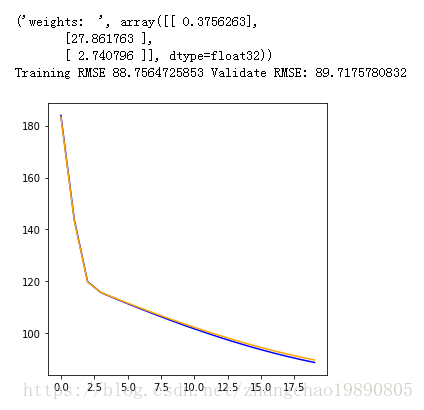4.png

最后，我们用测试集来测试模型：

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics
from IPython import display

class ZcValidateTest:
    # 从CSV文件中读取数据，返回DataFrame类型的数据集合。
    def read_csv(self, pa_url):
        v_dataframe = pd.read_csv(pa_url, sep=",")
        # 打乱数据集合的顺序。有时候数据文件有可能是根据某种顺序排列的，会影响到我们对数据的处理。
        v_dataframe = v_dataframe.reindex(np.random.permutation(v_dataframe.index))
        return v_dataframe
    
    # 预处理特征值
    def preprocess_features(self, california_housing_dataframe):
        selected_features = california_housing_dataframe[
            [
                "median_income",
                "latitude"
             ]
        ]
        processed_features = selected_features.copy()
        
        return processed_features


    # 预处理标签
    def preprocess_targets(self, california_housing_dataframe):
        output_targets = pd.DataFrame()
        # 数值过大可能引起训练过程中的错误。因此要把房价数值先缩小成原来的
        # 千分之一，然后作为标签值返回。
        output_targets["median_house_value"] = (
            california_housing_dataframe["median_house_value"] / 1000.0)
        return output_targets
    
    # 根据数学模型计算预测值。公式是 y = w0 + w1 * x1 + w2 * x2 .... + wN * xN
    def fn_predict(self, pa_dataframe, pa_weight_arr):
        v_result = []
        v_weight_num = len(pa_weight_arr)
        for var_row_index in pa_dataframe.index:
            y = pa_weight_arr[0]
            for v_index in range(v_weight_num-1):
                y = y + pa_weight_arr[v_index + 1] * pa_dataframe.loc[var_row_index].values[v_index]
            v_result.append(y)
        return v_result
    
     # 主函数
    def main(self):
        tf.logging.set_verbosity(tf.logging.ERROR)
        pd.options.display.max_rows = 10
        pd.options.display.float_format = '{:.1f}'.format
        
        # 通过训练模型得到的权重
        v_weight_arr = [0.3756263, 27.861763 , 2.740796 ]
        
        # 读取验证集
        california_housing_dataframe = self.read_csv("http://114.116.18.230/california_housing_train.csv")
        # 对于验证集，我们从共 17000 个样本中选择后 5000 个样本。
        validation_examples = self.preprocess_features(california_housing_dataframe.tail(5000))
        validation_targets = self.preprocess_targets(california_housing_dataframe.tail(5000))
        # 根据已经训练得到的模型系数，计算预验证集的预测值。
        v_validate_predict_arr = self.fn_predict(validation_examples, v_weight_arr)
        # 计算验证集的预测值和标签之间的均方根误差。
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(v_validate_predict_arr, validation_targets["median_house_value"]))
        print("validation RMSE:", validation_root_mean_squared_error)
        
        # 读取测试集
        test_dataframe = self.read_csv("http://114.116.18.230/california_housing_test.csv")
        test_examples = self.preprocess_features(test_dataframe)
        test_targets = self.preprocess_targets(test_dataframe)
        # 计算测试集的预测值
        v_test_predict_arr = self.fn_predict(test_examples, v_weight_arr)
        # 计算测试集的预测值和标签之间的均方根误差。
        test_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(v_test_predict_arr, test_targets["median_house_value"]))
        print("test RMSE:", test_root_mean_squared_error)
        

        
t = ZcValidateTest()
t.main()


运行结果

In [ ]:
('validation RMSE:', 88.49264785316481)
('test RMSE:', 88.18046581637961)